In [3]:
import networkx as nx
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

In [184]:
no_machines = 10
no_jobs = 30
d = np.random.randint(30,100, no_jobs)
r = np.random.randint(0,25, no_jobs)
w = np.random.rand(no_jobs)
v = np.random.randint(1,3,no_machines)
p = np.random.randint(1,4, (no_machines, no_jobs))*2
max_time = 40
no_machines_each_job_can_work_with = 3
F = np.empty((no_jobs, no_machines_each_job_can_work_with)) 
for j in range(no_jobs):
    F[j,:] = np.random.choice(no_machines, no_machines_each_job_can_work_with, replace = False)
#assumption: each job in the second half has 2 jobs as precedent from the first half
no_precedent_per_job = 2
prec = np.zeros((no_jobs, no_precedent_per_job), dtype = int) 
for j in range(int(no_jobs/2)):
    prec[10+j] = np.random.choice(int(no_jobs/2), no_precedent_per_job, replace = False)

In [185]:
G = nx.DiGraph()

In [186]:
for job in range(no_jobs):
    for i in prec[job,]:
        if i > 0:
            G.add_edge(str(job), str(i), weight=1)

In [187]:
try:
    nx.find_cycle(G)
    print("Error: There is a cycle in the precendece constraints")
except nx.exception.NetworkXNoCycle:
    print("Precedence constraints are valid; There are no cycles in the precedence constraints")

Precedence constraints are valid; There are no cycles in the precedence constraints


In [188]:
L = np.arange(max_time)
N = np.arange(no_jobs)
M = np.arange(no_machines)

θ1 = 0.8
θ2 = 0.2
try:
    # Create a new model
    m = gp.Model("scheduling2")

    # Create variables, x binary indicator variable that indicates whether job j starts at time time t
    x = m.addVars(M, N, L, vtype=GRB.BINARY, name="x")
    t = m.addVars(N, name="tardiness")
    C = m.addVar(name = "makespan")


    # Set objective, minimize weighted completion times, NP hard problem
    m.setObjective(θ1 * C + θ2 * sum(w[j]*t[j] for j in N), GRB.MINIMIZE)
        
    #define tardiness
    m.addConstrs((t[j] >= 0 for j in N),"one")
    m.addConstrs((t[j] >= sum(x[i,j,t] * (t + p[i,j]/v[i]) for i in M for t in L) - d[j] for j in N),"two")
        
    #define makespan
    m.addConstrs((C >= sum(x[i,j,t] * (t + p[i,j]/v[i]) for i in M for t in L) for j in N),"three")

    #jobs can be started only after their release date
    m.addConstrs((sum(x[i,j,t] * t for i in M for t in L) >= r[j] for j in N),"four")
        
    #jobs can only be started once, and they must all be started at least once
    m.addConstrs((sum(x[i,j,t] for i in M for t in L) == 1 for j in N),"five")
        
    #jobs can only be processed on machines they are eligible for 
    m.addConstrs((sum(x[i,j,t] for t in L) == 0 for j in N for i in np.setdiff1d(np.arange(no_machines), F[j,])), "six")
        
    #no overlap
    m.addConstrs(((sum(x[i,j,s] for j in N for s in np.arange(max(t-int(p[i,j]/v[i]), 0), max(0, t))) <= 1  for i in M for t in L)), "seven")
        
    #enforce precedence constraints
    m.addConstrs((sum(x[i,j,t] * (t + p[i,j]/v[i]) for i in M for t in L) <= sum(x[i,k,t] * t for i in M for t in L) for k in range(int(no_jobs/2), no_jobs) for j in prec[k]),"eight")
       
    # Optimize model
    m.optimize()
                 
  

    print('Obj: %g' % m.objVal)


except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))

except AttributeError:
    print('Encountered an attribute error')

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 790 rows, 12031 columns and 119502 nonzeros
Model fingerprint: 0x40a5d520
Variable types: 31 continuous, 12000 integer (12000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [8e-03, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 691 rows and 11765 columns
Presolve time: 0.06s
Presolved: 99 rows, 266 columns, 1167 nonzeros
Variable types: 0 continuous, 266 integer (265 binary)
Found heuristic solution: objective 34.4000000
Found heuristic solution: objective 24.0000000
Found heuristic solution: objective 23.2000000
Found heuristic solution: objective 22.4000000

Explored 0 nodes (0 simplex iterations) in 0.09 seconds
Thread count was 16 (of 16 available processors)

Solution count 4: 22.4 23.2 24 34.4 

Optimal solution found (tolerance 1.00e-04)
Best ob

In [241]:
res = {}
for i in range(no_machines):
    res[i] = []
    
    
for var in m.getVars():
        if var.x == 1:
            txt = var.varName[2:-1].split(",")
            machine = int(txt[0])
            job = int(txt[1])
            start_time = int(txt[2])
            processing_time = int(p[machine, job] / v[machine])
            end_time = start_time + processing_time
            res[machine] =  np.append(res[machine], np.arange(start_time, end_time+1))

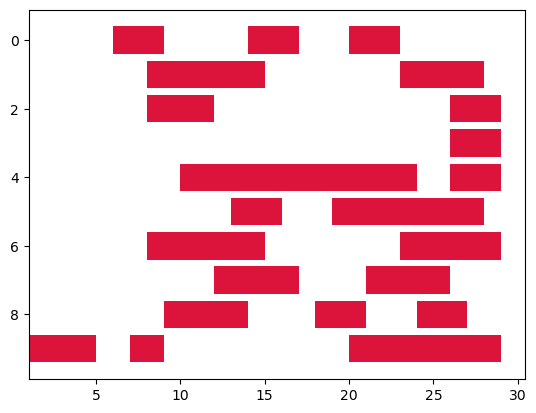

In [243]:
plt.rcdefaults()
fig, ax = plt.subplots()

performance = tmp

for y in M:
    for j in res[y]:
        ax.barh(y, width = 1, left = j, align='center', color='crimson')
ax.invert_yaxis()  # labels read top-to-bottom

plt.show()